In [1]:
%%javascript 
_=IPython.OutputArea.prototype._should_scroll = function(lines) {    return false;   }



<IPython.core.display.Javascript object>

In [64]:
import os, sys, pickle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, cohen_kappa_score
from scipy.stats import kendalltau
import glob
import numpy as np
from scipy.stats import rankdata

In [173]:
def sigmoid(x):
    return 1./(1+np.exp(-1.0*x))

# minimum error operating point
def operating_point(truth,results,ratio=None):
    # the ratio is the class pos-neg ratio
    # error is expected to be
    # ratio * (1-tpr) + (1-ratio)*fpr
    if ratio is None:
        ratio=np.mean(truth)
    fpr,tpr,thresh=roc_curve(truth,results)
    op_index=np.argmin( ratio * (1.-tpr) + (1.-ratio)*fpr)
    op_point=thresh[op_index]
    return op_point

# https://en.wikipedia.org/wiki/Youden%27s_J_statistic
# maximizes sensitivity+specificity-1
def youden(truth,results):
    #maximize sensitivity + specificity
    fpr,tpr,thresh=roc_curve(truth,results)
    op_index=np.argmax(tpr-fpr)
    op_point=thresh[op_index]
    return op_point

# maximize positive predictive value
def maxppvpoint(truth,results):
    #maximize sensitivity + specificity
    ratio=np.mean(truth)
    fpr,tpr,thresh=roc_curve(truth,results)
    # ppv is true positives / (true positives + false positives)
    # epsilon prevents division by zero
    op_index=np.argmax(ratio*tpr/(ratio*tpr+(1-ratio)*fpr+0.0001))
    op_point=thresh[op_index]
    return op_point



In [166]:
pathologies=['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural_Thickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung Opacity',
 'Enlarged Cardiomediastinum']
pathology_presentation_names=['Atelectasis',
 'Consolidation',
 'Infiltration',
 'Pneumothorax',
 'Edema',
 'Emphysema',
 'Fibrosis',
 'Effusion',
 'Pneumonia',
 'Pleural\nThickening',
 'Cardiomegaly',
 'Nodule',
 'Mass',
 'Hernia',
 'Lung Lesion',
 'Fracture',
 'Lung\nOpacity',
 'Enlarged\nCardiomediastinum']

# the openI and google dataset seems missing form what I have
datasets=['NIH','PC','CheX','MIMIC_CH','MIMIC_NB']#,'nihpcchexmimic_chmimic_nbgoogle']


In [164]:
# Data that I have
for f in sorted(glob.glob('results/*.pkl')):
    print(f)

results\results-da-new-seeds-tsCheX-mCheX.pkl
results\results-da-new-seeds-tsCheX-mMIMIC_CH.pkl
results\results-da-new-seeds-tsCheX-mMIMIC_NB.pkl
results\results-da-new-seeds-tsCheX-mNIH.pkl
results\results-da-new-seeds-tsCheX-mPC.pkl
results\results-da-new-seeds-tsCheX-mnihpcchexmimic_chmimic_nbgoogle.pkl
results\results-da-new-seeds-tsMIMIC_CH-mCheX.pkl
results\results-da-new-seeds-tsMIMIC_CH-mMIMIC_CH.pkl
results\results-da-new-seeds-tsMIMIC_CH-mMIMIC_NB.pkl
results\results-da-new-seeds-tsMIMIC_CH-mNIH.pkl
results\results-da-new-seeds-tsMIMIC_CH-mPC.pkl
results\results-da-new-seeds-tsMIMIC_CH-mnihpcchexmimic_chmimic_nbgoogle.pkl
results\results-da-new-seeds-tsMIMIC_NB-mCheX.pkl
results\results-da-new-seeds-tsMIMIC_NB-mMIMIC_CH.pkl
results\results-da-new-seeds-tsMIMIC_NB-mMIMIC_NB.pkl
results\results-da-new-seeds-tsMIMIC_NB-mNIH.pkl
results\results-da-new-seeds-tsMIMIC_NB-mPC.pkl
results\results-da-new-seeds-tsMIMIC_NB-mnihpcchexmimic_chmimic_nbgoogle.pkl
results\results-da-new-seeds

In [75]:
# load all the data
data=dict()
for d_test in datasets:
    for d_train in datasets:
        filename='results/results-da-new-seeds-ts{0}-m{1}.pkl'.format(d_test,d_train)
        check=os.path.exists(filename)
        assert(check)
        #print(filename,check)
        data[(d_test,d_train)]=pickle.load(open(filename,'rb'))
        


Text(0.5, 1.0, 'Legitimate combinations')

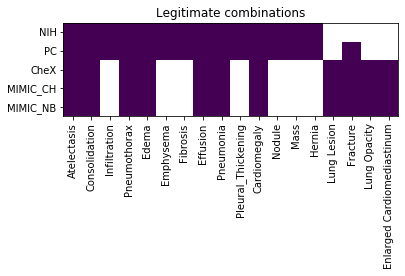

In [80]:
# legit combos of pathology and dataset are where there is at least one positive in the test set
legit=dict()
for d_test in datasets:
    truth=data[(d_test,'NIH')][0][3]
    for p,pathology in enumerate(pathologies):
        legit[(d_test,pathology)]=np.sum(truth[p])>0
z=np.zeros((len(datasets),len(pathologies)))*np.nan
for i,d in enumerate(datasets):
    for j,p in enumerate(pathologies):
        if legit[(d,p)]:
            z[i,j]=1
plt.imshow(z)
xl=plt.xlim()
yl=plt.ylim()
plt.yticks(range(len(datasets)),datasets)
plt.xticks(range(len(pathologies)),pathologies,rotation=90)
# for some reason setting the ticks fiddles the limits in y but not x.  Set it back
plt.xlim(xl)
plt.ylim(yl)
plt.title("Legitimate combinations")

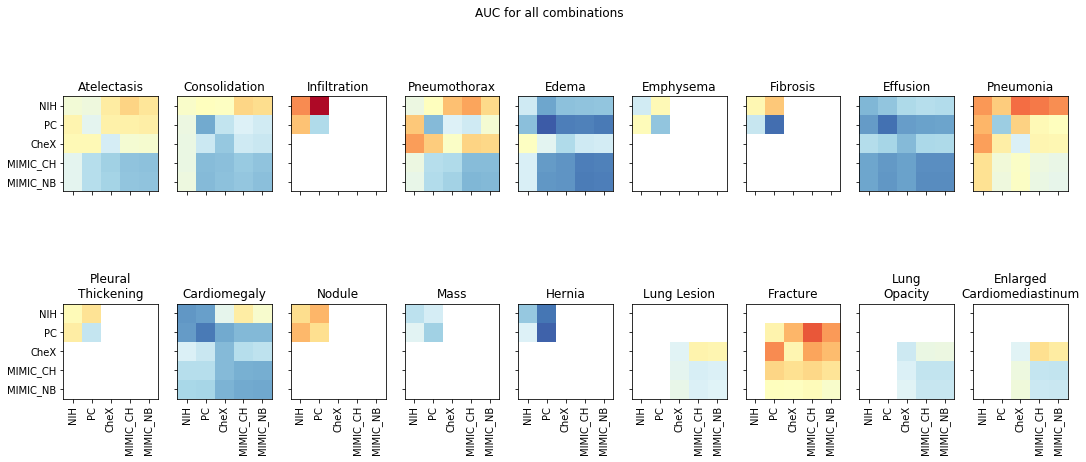

In [81]:
# compute AUC of all combinations
# should be similar to fig 1 in paper
fig=plt.figure(figsize=(18,7))
z=np.zeros((len(datasets),len(datasets)))
for p,pathology in enumerate(pathologies):
    for i,d_test in enumerate(datasets):
        for j,d_train in enumerate(datasets):
            if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                truth=data[(d_test,d_train)][0][3][p]
                results=(data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.
                auc=roc_auc_score(truth,results)
            else:
                auc=np.nan
            z[i,j]=auc

    plt.subplot(2,9,p+1)
    plt.imshow(z,vmin=0.5,vmax=1.,cmap='RdYlBu')
    xl=plt.xlim()
    yl=plt.ylim()
    
    if p==0 or p==9:
        plt.yticks(range(len(datasets)),datasets)
    else:
        plt.yticks(range(len(datasets)),[None]*len(datasets))
        
    if p<9:
        plt.xticks(range(len(datasets)),[None]*len(datasets))
    else:
        plt.xticks(range(len(datasets)),datasets,rotation=90)
    # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
    plt.xlim(xl)
    plt.ylim(yl)
    #plt.gca().xticklabels([])
    #plt.gca().yticklabels([])
    
    plt.title(pathology_presentation_names[p])
plt.suptitle("AUC for all combinations")
plt.show()
plt.close(fig)

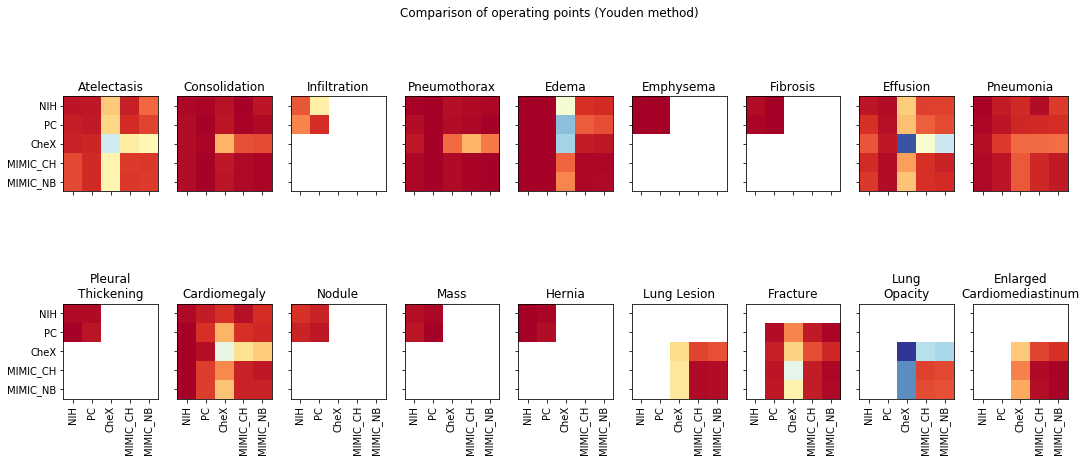

In [119]:
# plot the operating point
# turned out not that visually interesting
fig=plt.figure(figsize=(18,7))
z=np.zeros((len(datasets),len(datasets)))
for p,pathology in enumerate(pathologies):
    for i,d_test in enumerate(datasets):
        for j,d_train in enumerate(datasets):
            if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                truth=data[(d_test,d_train)][0][3][p]
                results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                op_point=youden(truth,results)
            else:
                op_point=np.nan
            z[i,j]=op_point

    plt.subplot(2,9,p+1)
    plt.imshow(z,vmin=0.0,vmax=.5,cmap='RdYlBu')
    xl=plt.xlim()
    yl=plt.ylim()
    
    if p==0 or p==9:
        plt.yticks(range(len(datasets)),datasets)
    else:
        plt.yticks(range(len(datasets)),[None]*len(datasets))
        
    if p<9:
        plt.xticks(range(len(datasets)),[None]*len(datasets))
    else:
        plt.xticks(range(len(datasets)),datasets,rotation=90)
    # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
    plt.xlim(xl)
    plt.ylim(yl)
    #plt.gca().xticklabels([])
    #plt.gca().yticklabels([])
    
    plt.title(pathology_presentation_names[p])
plt.suptitle("Comparison of operating points (Youden method)")
plt.show()
plt.close(fig)

In [168]:
maxlen=11
def trim_len(s):
    return s[:min(len(s),maxlen)]
indexed_pathologies=list(enumerate(pathologies))
pathology_subsets=[indexed_pathologies[:6],indexed_pathologies[6:12],indexed_pathologies[12:]]
for pathology_subset in pathology_subsets:
    print("============================ Positive counts =========================")
    format_string=" ".join(["%%%ds"%maxlen]*(2+len(pathology_subset)))
    def printline(ss):
        print(format_string%tuple(map(trim_len,ss)))
    _,pathology_subset_names=zip(*pathology_subset)
    printline(["test set","N"]+list(pathology_subset_names))
    d_train=datasets[0]
    for i,d_test in enumerate(datasets):
        result_strings=[]
        for p,pathology in pathology_subset:
            if legit[(d_test,pathology)]:
                N=len(truth)
                truth=data[(d_test,d_train)][0][3][p]
                result_strings.append("%d %d%%"%(np.sum(truth),np.round(np.sum(truth)/len(truth))))
            else:
                result_strings.append("--")
        result_strings=[d_test,str(N)]+result_strings
        printline(result_strings)

print("\n\n\nCompare accuracy at operating point vs baseline (all negative)")

for pathology_subset in pathology_subsets:
    print("=================  Operating point accuracy / Base accuracy ===============")
    format_string=" ".join(["%%%ds"%maxlen]*(2+len(pathology_subset)))
    def printline(ss):
        print(format_string%tuple(map(trim_len,ss)))
    _,pathology_subset_names=zip(*pathology_subset)
    printline(["trained on","tested on"]+list(pathology_subset_names))
    for j,d_train in enumerate(datasets):
        for i,d_test in enumerate(datasets):
            result_strings=[d_train,d_test]
            for p,pathology in pathology_subset:

                if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                    truth=data[(d_test,d_train)][0][3][p]
                    results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                    op_point=youden(truth,results)
                    acc1=np.mean(1.0*(results>op_point) ==truth)
                    acc2=max(np.mean(truth),np.mean(1-truth))
                    #result_strings.append("%.2f/%.2f/%.2f"%(acc1,acc2,acc3))
                    result_strings.append("%.2f/%.2f"%(acc1,acc2))
                else:
                    result_strings.append("--")
            printline(result_strings)

print("\n\n\nCompare accuracy at youden operating point vs accuracy at ppv operating point")
            
for pathology_subset in pathology_subsets:
    print("=================  operating point accuracy / ppv accuracy ===============")
    format_string=" ".join(["%%%ds"%maxlen]*(2+len(pathology_subset)))
    def printline(ss):
        print(format_string%tuple(map(trim_len,ss)))
    _,pathology_subset_names=zip(*pathology_subset)
    printline(["trained on","tested on"]+list(pathology_subset_names))
    for j,d_train in enumerate(datasets):
        for i,d_test in enumerate(datasets):
            result_strings=[d_train,d_test]
            for p,pathology in pathology_subset:

                if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                    truth=data[(d_test,d_train)][0][3][p]
                    results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                    op_point=youden(truth,results)
                    op_point_ppv=maxppvpoint(truth,results)
                    acc1=np.mean(1.0*(results>op_point) ==truth)
                    acc2=np.mean(1.0*(results>op_point_ppv) ==truth)
                    #result_strings.append("%.2f/%.2f/%.2f"%(acc1,acc2,acc3))
                    result_strings.append("%.2f/%.2f"%(acc1,acc2))
                else:
                    result_strings.append("--")
            printline(result_strings)

print("\n\n\n")


print("\n\n\nCompare ppv at youden operating point vs ppv at ppv operating point")
            
for pathology_subset in pathology_subsets:
    print("=================  youden ppv / max ppv ===============")
    format_string=" ".join(["%%%ds"%maxlen]*(2+len(pathology_subset)))
    def printline(ss):
        print(format_string%tuple(map(trim_len,ss)))
    _,pathology_subset_names=zip(*pathology_subset)
    printline(["trained on","tested on"]+list(pathology_subset_names))
    for j,d_train in enumerate(datasets):
        for i,d_test in enumerate(datasets):
            result_strings=[d_train,d_test]
            for p,pathology in pathology_subset:

                if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                    truth=data[(d_test,d_train)][0][3][p]
                    results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                    op_point=youden(truth,results)
                    op_point_ppv=maxppvpoint(truth,results)
                    tp=np.sum(np.logical_and(results>op_point,truth))
                    tp_ppv=np.sum(np.logical_and(results>op_point_ppv,truth))
                    if tp==0:
                        ppv1=0
                    else:
                        ppv1=tp/np.sum(results>op_point)
                    if tp_ppv==0:
                        ppv2=0
                    else:
                        ppv2=tp_ppv/np.sum(results>op_point_ppv)
                    result_strings.append("%.2f/%.2f"%(ppv1,ppv2))
                else:
                    result_strings.append("--")
            printline(result_strings)

print("\n\n\nSensitivity and specificity at youden point of local data/of training data")


for pathology_subset in pathology_subsets:
    print("=============  Sensitivity own thresh / Sensitivity training thresh ===================")
    print("=============  Specificity own thresh / Specificity training thresh ===================")
    format_string=" ".join(["%%%ds"%maxlen]*(2+len(pathology_subset)))
    def printline(ss):
        print(format_string%tuple(map(trim_len,ss)))
    _,pathology_subset_names=zip(*pathology_subset)
    printline(["trained on","tested on"]+list(pathology_subset_names))
    for j,d_train in enumerate(datasets):
        for i,d_test in enumerate(datasets):
            result_strings1=[d_train,d_test]
            result_strings2=['','']
            for p,pathology in pathology_subset:
                if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                    truth_train=data[(d_train,d_train)][0][3][p]
                    results_train=sigmoid((data[(d_train,d_train)][0][2][p]+data[(d_train,d_train)][1][2][p]+data[(d_train,d_train)][2][2][p])/3.)
                    op_point_train=youden(truth_train,results_train)
                    truth=data[(d_test,d_train)][0][3][p]
                    results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                    op_point=youden(truth,results)
                    tp=np.sum((results>op_point)*truth)
                    tn=np.sum((results<=op_point)*(1-truth))
                    tp_train=np.sum((results>op_point_train)*truth)
                    tn_train=np.sum((results<=op_point_train)*(1-truth))
                    #print(d_test,d_train,pathology,op_point,op_point_train,tp,tn,tp_train,tn_train)
                    sens1=tp/np.sum(truth)
                    senstrain=tp_train/np.sum(truth)
                    spec1=tn/np.sum(1.-truth)
                    spectrain=tn_train/np.sum(1.-truth)
                    #result_strings.append("%.2f/%.2f/%.2f"%(acc1,acc2,acc3))
                    result_strings1.append("%.2f/%.2f"%(sens1,senstrain))
                    result_strings2.append("%.2f/%.2f"%(spec1,spectrain))
                else:
                    result_strings1.append("--")
                    result_strings2.append("--")
            printline(result_strings1)
            printline(result_strings2)



============================ Positive counts =========================
   test set           N Atelectasis Consolidati Infiltratio Pneumothora       Edema   Emphysema
        NIH       15403      866 0%      203 0%     1809 0%      136 0%       41 0%      126 0%
         PC       31058     1237 0%      251 0%     2196 0%       43 0%       32 0%      277 0%
       CheX       18498     6350 0%     2728 0%          --     2212 0%     7446 0%          --
   MIMIC_CH       17122     2046 0%      395 0%          --      273 0%      597 0%          --
   MIMIC_NB       17660     2021 0%      375 0%          --      246 0%      575 0%          --
============================ Positive counts =========================
   test set           N    Fibrosis    Effusion   Pneumonia Pleural_Thi Cardiomegal      Nodule
        NIH       15403      292 0%      656 0%       87 0%      379 0%      399 0%      806 0%
         PC       31058      166 0%      805 0%     1010 0%     1053 0%     2711 0%     11

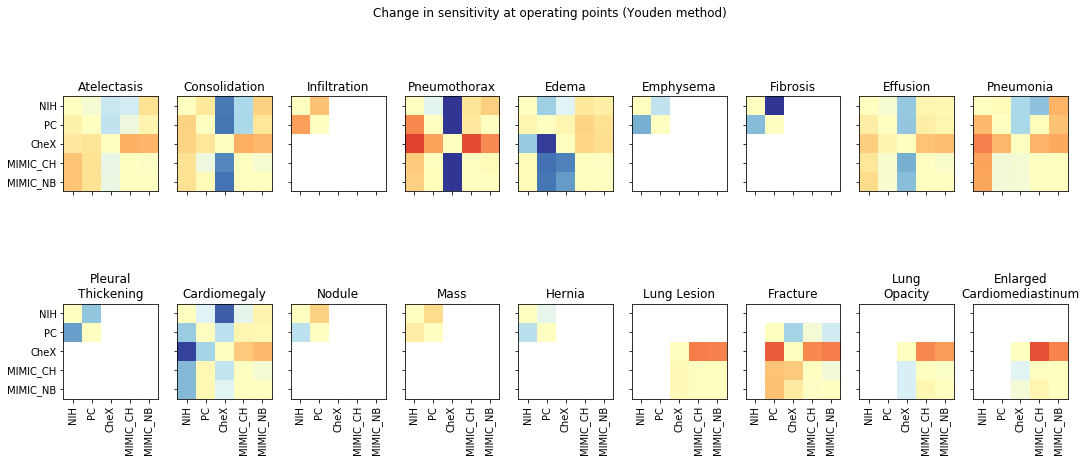

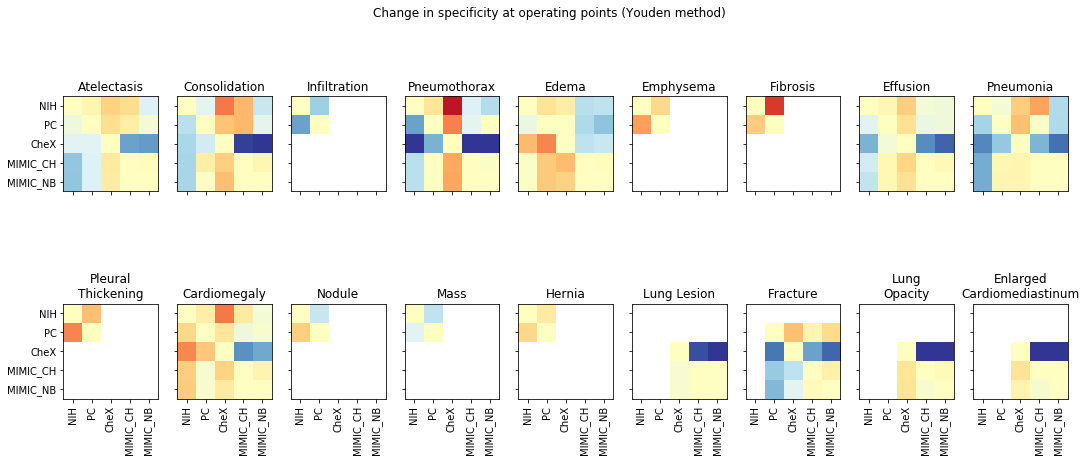

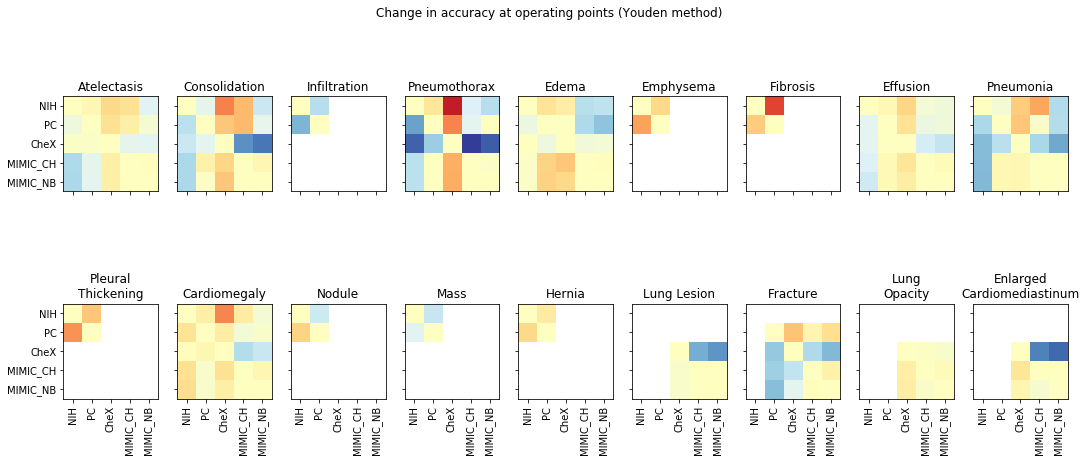

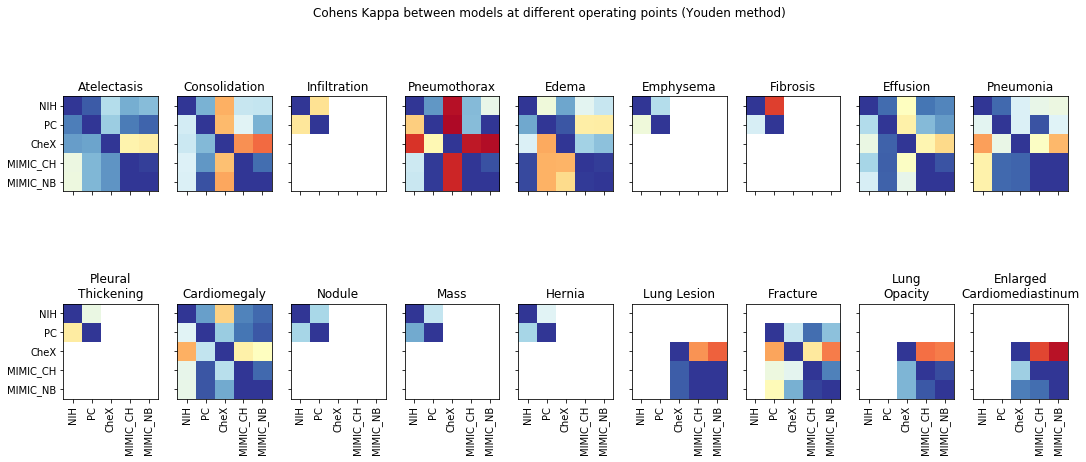

In [162]:
fig=plt.figure(figsize=(18,7))
z=np.zeros((len(datasets),len(datasets)))
for p,pathology in enumerate(pathologies):
    for i,d_test in enumerate(datasets):
        for j,d_train in enumerate(datasets):
            if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                truth_train=data[(d_train,d_train)][0][3][p]
                results_train=sigmoid((data[(d_train,d_train)][0][2][p]+data[(d_train,d_train)][1][2][p]+data[(d_train,d_train)][2][2][p])/3.)
                op_point_train=youden(truth_train,results_train)
                truth=data[(d_test,d_train)][0][3][p]
                results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                op_point=youden(truth,results)
                tp=np.sum((results>op_point)*truth)
                tn=np.sum((results<=op_point)*(1-truth))
                tp_train=np.sum((results>op_point_train)*truth)
                tn_train=np.sum((results<=op_point_train)*(1-truth))
                #print(d_test,d_train,pathology,op_point,op_point_train,tp,tn,tp_train,tn_train)
                sens1=tp/np.sum(truth)
                senstrain=tp_train/np.sum(truth)
                spec1=tn/np.sum(1.-truth)
                spectrain=tn_train/np.sum(1.-truth)
                z[i,j]=sens1-senstrain
            else:
                z[i,j]=np.nan

    plt.subplot(2,9,p+1)
    plt.imshow(z,vmin=-0.5,vmax=.5,cmap='RdYlBu')
    xl=plt.xlim()
    yl=plt.ylim()
    
    if p==0 or p==9:
        plt.yticks(range(len(datasets)),datasets)
    else:
        plt.yticks(range(len(datasets)),[None]*len(datasets))
        
    if p<9:
        plt.xticks(range(len(datasets)),[None]*len(datasets))
    else:
        plt.xticks(range(len(datasets)),datasets,rotation=90)
    # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
    plt.xlim(xl)
    plt.ylim(yl)
    #plt.gca().xticklabels([])
    #plt.gca().yticklabels([])
    
    plt.title(pathology_presentation_names[p])
plt.suptitle("Change in sensitivity at operating points (Youden method)")
plt.show()
plt.close(fig)



fig=plt.figure(figsize=(18,7))
z=np.zeros((len(datasets),len(datasets)))
for p,pathology in enumerate(pathologies):
    for i,d_test in enumerate(datasets):
        for j,d_train in enumerate(datasets):
            if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                truth_train=data[(d_train,d_train)][0][3][p]
                results_train=sigmoid((data[(d_train,d_train)][0][2][p]+data[(d_train,d_train)][1][2][p]+data[(d_train,d_train)][2][2][p])/3.)
                op_point_train=youden(truth_train,results_train)
                truth=data[(d_test,d_train)][0][3][p]
                results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                op_point=youden(truth,results)
                tp=np.sum((results>op_point)*truth)
                tn=np.sum((results<=op_point)*(1-truth))
                tp_train=np.sum((results>op_point_train)*truth)
                tn_train=np.sum((results<=op_point_train)*(1-truth))
                #print(d_test,d_train,pathology,op_point,op_point_train,tp,tn,tp_train,tn_train)
                sens1=tp/np.sum(truth)
                senstrain=tp_train/np.sum(truth)
                spec1=tn/np.sum(1.-truth)
                spectrain=tn_train/np.sum(1.-truth)
                z[i,j]=spec1-spectrain
            else:
                z[i,j]=np.nan

    plt.subplot(2,9,p+1)
    plt.imshow(z,vmin=-0.5,vmax=.5,cmap='RdYlBu')
    xl=plt.xlim()
    yl=plt.ylim()
    
    if p==0 or p==9:
        plt.yticks(range(len(datasets)),datasets)
    else:
        plt.yticks(range(len(datasets)),[None]*len(datasets))
        
    if p<9:
        plt.xticks(range(len(datasets)),[None]*len(datasets))
    else:
        plt.xticks(range(len(datasets)),datasets,rotation=90)
    # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
    plt.xlim(xl)
    plt.ylim(yl)
    #plt.gca().xticklabels([])
    #plt.gca().yticklabels([])
    
    plt.title(pathology_presentation_names[p])
plt.suptitle("Change in specificity at operating points (Youden method)")
plt.show()
plt.close(fig)


fig=plt.figure(figsize=(18,7))
z=np.zeros((len(datasets),len(datasets)))
for p,pathology in enumerate(pathologies):
    for i,d_test in enumerate(datasets):
        for j,d_train in enumerate(datasets):
            if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                truth_train=data[(d_train,d_train)][0][3][p]
                results_train=sigmoid((data[(d_train,d_train)][0][2][p]+data[(d_train,d_train)][1][2][p]+data[(d_train,d_train)][2][2][p])/3.)
                op_point_train=youden(truth_train,results_train)
                truth=data[(d_test,d_train)][0][3][p]
                results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                op_point=youden(truth,results)
                acc_train=np.mean(1.0*(results>op_point_train) ==truth)
                acc=np.mean(1.0*(results>op_point) ==truth)

                tp=np.sum((results>op_point)*truth)
                tn=np.sum((results<=op_point)*(1-truth))
                tp_train=np.sum((results>op_point_train)*truth)
                tn_train=np.sum((results<=op_point_train)*(1-truth))
                #print(d_test,d_train,pathology,op_point,op_point_train,tp,tn,tp_train,tn_train)
                sens1=tp/np.sum(truth)
                senstrain=tp_train/np.sum(truth)
                spec1=tn/np.sum(1.-truth)
                spectrain=tn_train/np.sum(1.-truth)
                z[i,j]=acc-acc_train
            else:
                z[i,j]=np.nan

    plt.subplot(2,9,p+1)
    plt.imshow(z,vmin=-0.5,vmax=.5,cmap='RdYlBu')
    xl=plt.xlim()
    yl=plt.ylim()
    
    if p==0 or p==9:
        plt.yticks(range(len(datasets)),datasets)
    else:
        plt.yticks(range(len(datasets)),[None]*len(datasets))
        
    if p<9:
        plt.xticks(range(len(datasets)),[None]*len(datasets))
    else:
        plt.xticks(range(len(datasets)),datasets,rotation=90)
    # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
    plt.xlim(xl)
    plt.ylim(yl)
    #plt.gca().xticklabels([])
    #plt.gca().yticklabels([])
    
    plt.title(pathology_presentation_names[p])
plt.suptitle("Change in accuracy at operating points (Youden method)")
plt.show()
plt.close(fig)



fig=plt.figure(figsize=(18,7))
z=np.zeros((len(datasets),len(datasets)))
for p,pathology in enumerate(pathologies):
    for i,d_test in enumerate(datasets):
        for j,d_train in enumerate(datasets):
            if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                truth_train=data[(d_train,d_train)][0][3][p]
                results_train=sigmoid((data[(d_train,d_train)][0][2][p]+data[(d_train,d_train)][1][2][p]+data[(d_train,d_train)][2][2][p])/3.)
                op_point_train=youden(truth_train,results_train)
                truth=data[(d_test,d_train)][0][3][p]
                results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                op_point=youden(truth,results)

                z[i,j]=cohen_kappa_score(results>op_point,results>op_point_train)
            else:
                z[i,j]=np.nan

    plt.subplot(2,9,p+1)
    plt.imshow(z,vmin=0,vmax=1,cmap='RdYlBu')
    xl=plt.xlim()
    yl=plt.ylim()
    
    if p==0 or p==9:
        plt.yticks(range(len(datasets)),datasets)
    else:
        plt.yticks(range(len(datasets)),[None]*len(datasets))
        
    if p<9:
        plt.xticks(range(len(datasets)),[None]*len(datasets))
    else:
        plt.xticks(range(len(datasets)),datasets,rotation=90)
    # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
    plt.xlim(xl)
    plt.ylim(yl)
    #plt.gca().xticklabels([])
    #plt.gca().yticklabels([])
    
    plt.title(pathology_presentation_names[p])
plt.suptitle("Cohens Kappa between models at different operating points (Youden method)")
plt.show()
plt.close(fig)




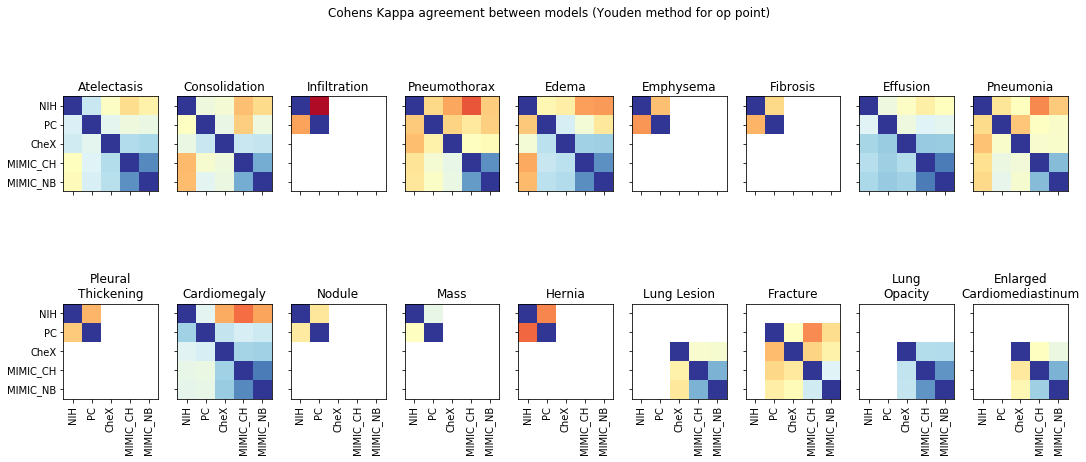

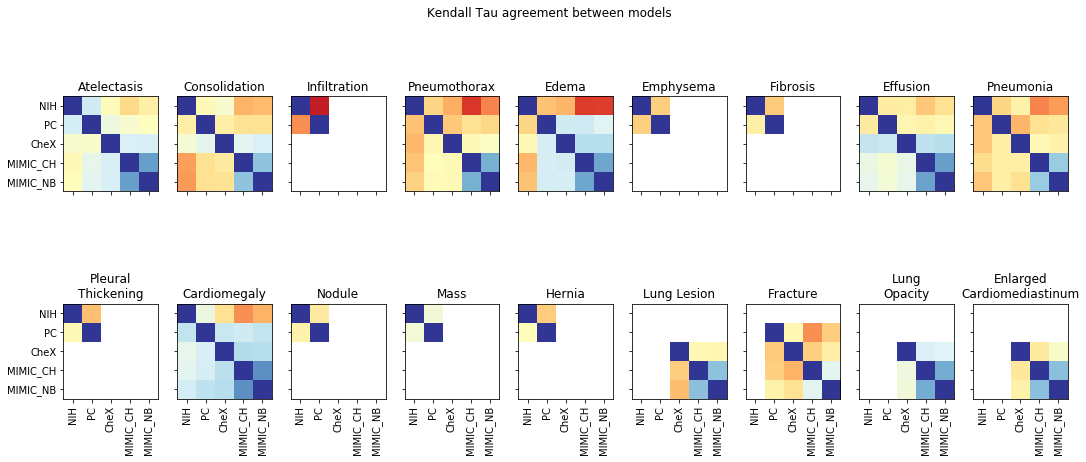

In [169]:
for theCase in ['kappa','kendalltau']:
    fig=plt.figure(figsize=(18,7))
    z=np.zeros((len(datasets),len(datasets)))
    for p,pathology in enumerate(pathologies):
        for i,d_test in enumerate(datasets):
            for j,d_train in enumerate(datasets):
                if legit[(d_test,pathology)] and legit[(d_train,pathology)]:
                    truth=data[(d_test,d_train)][0][3][p]
                    results_test=sigmoid((data[(d_test,d_test)][0][2][p]+data[(d_test,d_test)][1][2][p]+data[(d_test,d_test)][2][2][p])/3.)
                    op_point_test=youden(truth,results_test)
                    results=sigmoid((data[(d_test,d_train)][0][2][p]+data[(d_test,d_train)][1][2][p]+data[(d_test,d_train)][2][2][p])/3.)
                    op_point=youden(truth,results)
                    if theCase=="kappa":
                        z[i,j]=cohen_kappa_score(results>op_point,results_test>op_point_test)
                    elif theCase=='kendalltau':
                        z[i,j],_=kendalltau(results,results_test)
                    else:
                        #wut
                        raise
                else:
                    z[i,j]=np.nan

        plt.subplot(2,9,p+1)
        plt.imshow(z,vmin=0,vmax=1,cmap='RdYlBu')
        xl=plt.xlim()
        yl=plt.ylim()

        if p==0 or p==9:
            plt.yticks(range(len(datasets)),datasets)
        else:
            plt.yticks(range(len(datasets)),[None]*len(datasets))

        if p<9:
            plt.xticks(range(len(datasets)),[None]*len(datasets))
        else:
            plt.xticks(range(len(datasets)),datasets,rotation=90)
        # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
        plt.xlim(xl)
        plt.ylim(yl)
        #plt.gca().xticklabels([])
        #plt.gca().yticklabels([])

        plt.title(pathology_presentation_names[p])
    if theCase=="kappa":
        plt.suptitle("Cohens Kappa agreement between models (Youden method for op point)")
    elif theCase=='kendalltau':
        plt.suptitle("Kendall Tau agreement between models")
    else:
        #wut
        raise
    plt.show()
    plt.close(fig)



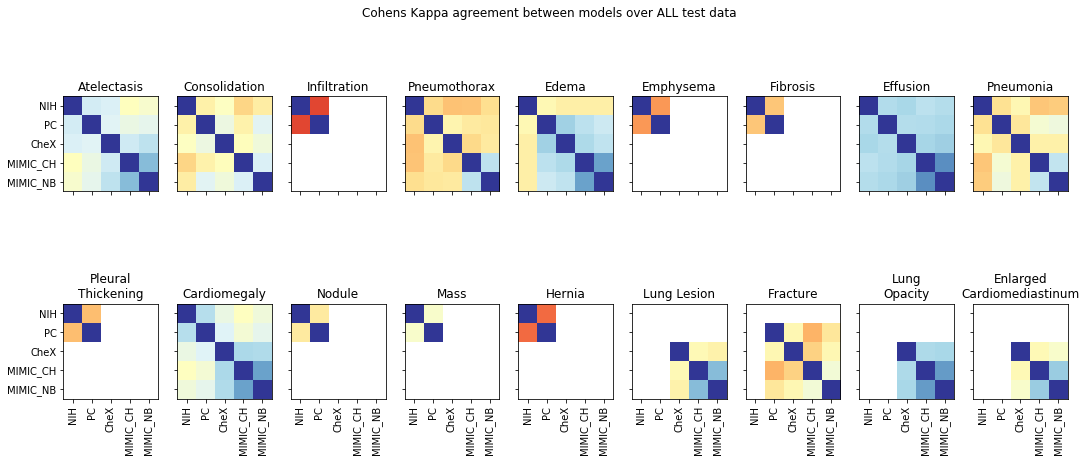

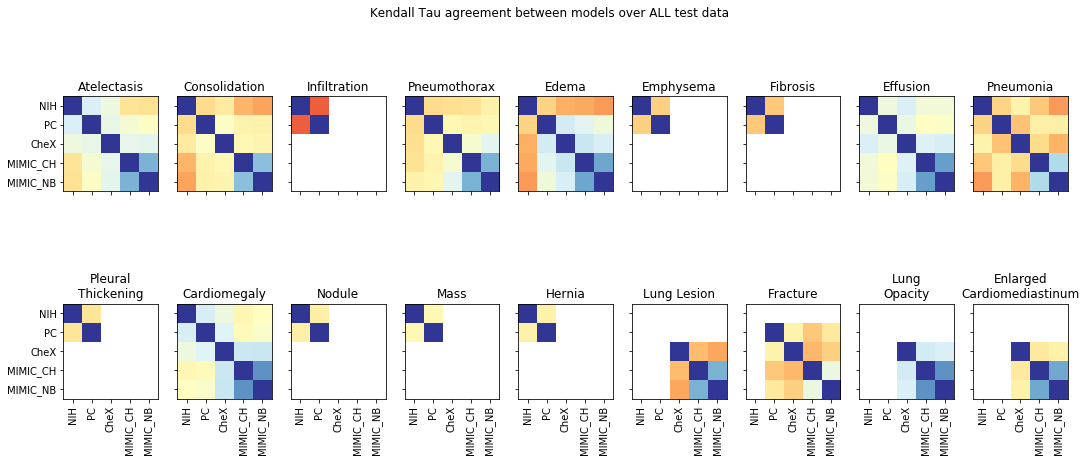

In [171]:
for theCase in ['kappa','kendalltau']:
    fig=plt.figure(figsize=(18,7))
    z=np.zeros((len(datasets),len(datasets)))
    for p,pathology in enumerate(pathologies):
        for i,d_train1 in enumerate(datasets):
            for j,d_train2 in enumerate(datasets):
                if legit[(d_train1,pathology)] and legit[(d_train2,pathology)]:
                    truth=[]
                    results1=[]
                    results2=[]
                    classed1=[]
                    classed2=[]
                    for k,d_test in enumerate(datasets):
                        if legit[(d_test,pathology)]:
                            t=data[(d_test,d_train1)][0][3][p]
                            truth.append(t)
                            assert(np.sum(t)>1)
                            r1=sigmoid((data[(d_test,d_train1)][0][2][p]+data[(d_test,d_train1)][1][2][p]+data[(d_test,d_train1)][2][2][p])/3.)
                            op_point1=youden(t,r1)
                            classed1.append(r1>op_point1)
                            r2=sigmoid((data[(d_test,d_train2)][0][2][p]+data[(d_test,d_train2)][1][2][p]+data[(d_test,d_train2)][2][2][p])/3.)
                            op_point2=youden(t,r2)
                            classed2.append(r2>op_point2)
                            results1.append(r1)
                            results2.append(r2)
                    if theCase=="kappa":
                        z[i,j]=cohen_kappa_score(np.concatenate(classed1),np.concatenate(classed2))
                    elif theCase=='kendalltau':
                        z[i,j],_=kendalltau(np.concatenate(results1),np.concatenate(results2))
                    else:
                        #wut
                        raise
                else:
                    z[i,j]=np.nan

        plt.subplot(2,9,p+1)
        plt.imshow(z,vmin=0.0,vmax=1.,cmap='RdYlBu')
        xl=plt.xlim()
        yl=plt.ylim()

        if p==0 or p==9:
            plt.yticks(range(len(datasets)),datasets)
        else:
            plt.yticks(range(len(datasets)),[None]*len(datasets))

        if p<9:
            plt.xticks(range(len(datasets)),[None]*len(datasets))
        else:
            plt.xticks(range(len(datasets)),datasets,rotation=90)
        # for some reason setting the ticks fiddles the limits in y but not x.  Set it back
        plt.xlim(xl)
        plt.ylim(yl)
        #plt.gca().xticklabels([])
        #plt.gca().yticklabels([])

        plt.title(pathology_presentation_names[p])
    if theCase=="kappa":
        plt.suptitle("Cohens Kappa agreement between models over ALL test data")
    elif theCase=='kendalltau':
        plt.suptitle("Kendall Tau agreement between models over ALL test data")
    else:
        #wut
        raise
    plt.show()
    plt.close(fig)

In [183]:
def rescale_to_operating_point(v,op_point):
    omv=1.0-v
    return v*(0.5/op_point)*(v<=op_point)+  (1.0 - omv*(0.5/(1.0-op_point))) *(v>op_point)
def ba_plot(a,b,*args,**kwargs):
    return plt.plot((a+b)/2.0,(a-b),*args,**kwargs)
    
def ba_plot_here(a,b,t,title):
    fig=plt.figure(figsize=(8,8))

    #ba_plot(v1_rescaled[t1<0.5],v2_rescaled[t1<0.5],'b.',alpha=0.3)
    #ba_plot(v1_rescaled[t1>=0.5],v2_rescaled[t1>=0.5],'k.',alpha=0.3)
    ba_plot(a[t<0.5],b[t<0.5],'b.',alpha=0.3)
    ba_plot(a[t>=0.5],b[t>=0.5],'k.',alpha=0.3)
    plt.xlim([-0.1,1.1])
    plt.ylim([-1,1])
    plt.title(title)
    plt.show()
    plt.close(fig)

Pathology Atelectasis


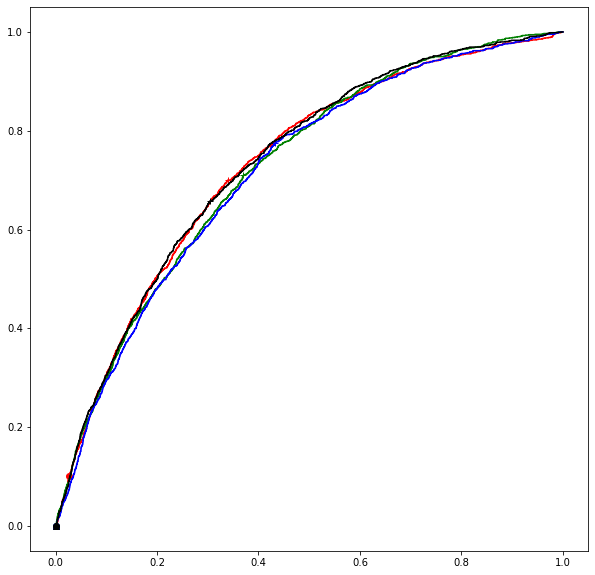

In [181]:
#Examine the operating points and roc curves for three of the same models

d_train='NIH'
d_test='PC'
p=0
print("Pathology",pathologies[p])
z=data[(d_test,d_train)]
fig=plt.figure(figsize=(10,10))

vs=[]
ts=[]
colors=['r','g','b','k']
for i in range(4):
    if i<3:
       v=sigmoid(z[i][2][p])
       t=z[i][3][p]
       vs.append(v)
       ts.append(t)
    else:
        v=(vs[0]+vs[1]+vs[2])/3.
        assert(np.all(ts[0]==ts[1]) and np.all(ts[1]==ts[2]))
        t=ts[0]
    fpr,tpr,thresh=roc_curve(t,v)
    youden_pt=youden(t,v)
    maxppv_pt=maxppvpoint(t,v)
    minerr_pt=operating_point(t,v)
    c=colors[i]
    plt.plot(fpr,tpr,c+'-')
    plt.plot(fpr[np.where(thresh==youden_pt)[0][0]],tpr[np.where(thresh==youden_pt)[0][0]],c+'+')
    plt.plot(fpr[np.where(thresh==maxppv_pt)[0][0]],tpr[np.where(thresh==maxppv_pt)[0][0]],c+'o')
    plt.plot(fpr[np.where(thresh==minerr_pt)[0][0]],tpr[np.where(thresh==minerr_pt)[0][0]],c+'^')

# plt.plot(fpr1,tpr1,'g-')
# plt.plot(fpr1[op_index1],tpr1[op_index1],'g+')

# plt.plot(fpr2,tpr2,'b-')
# plt.plot(fpr2[op_index2],tpr2[op_index2],'b+')

# plt.plot(fpra,tpra,'k-')
# plt.plot(fpra[op_indexa],tpra[op_indexa],'k+')


plt.show()
plt.close(fig)



Pathology Atelectasis


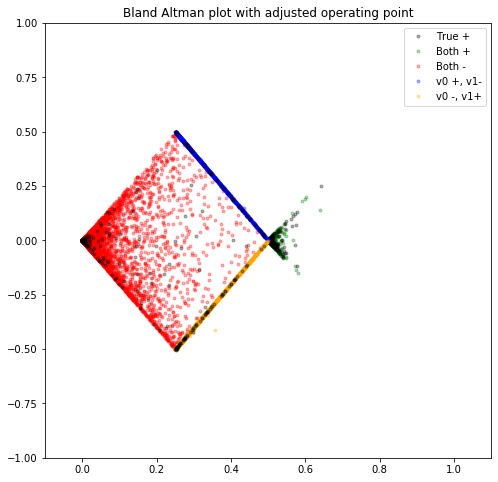

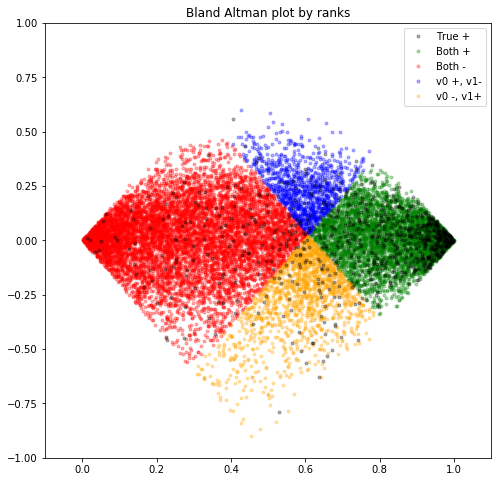

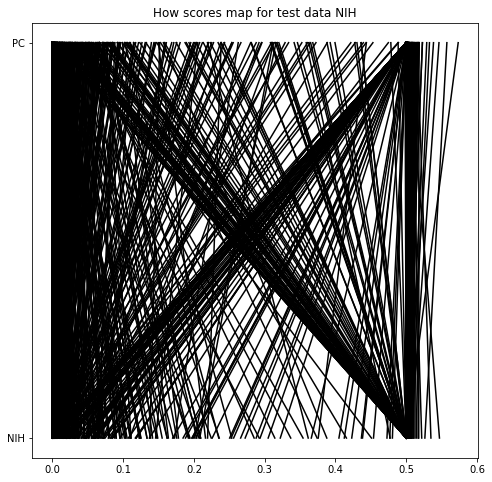

In [192]:
d_test='NIH'
d_train0='NIH'
d_train1='PC'
p=0
print("Pathology",pathologies[p])
z0=data[(d_test,d_train0)]
z1=data[(d_test,d_train1)]

truth=z0[0][3][p]
results0=sigmoid(z0[0][2][p]+z0[1][2][p]+z0[2][2][p])
results1=sigmoid(z1[0][2][p]+z1[1][2][p]+z1[2][2][p])
op_point0=youden(truth,results0)
op_point1=youden(truth,results1)
r0_rescaled=rescale_to_operating_point(results0,op_point0)
r1_rescaled=rescale_to_operating_point(results1,op_point1)

r0_idx=rankdata(results0,'dense')/len(results0)
r1_idx=rankdata(results1,'dense')/len(results0)




# c=np.logical_and(v0_rescaled>=0.5,v1_rescaled>=0.5)
# ba_plot_here(v0_idx[c],v1_idx[c],t1[c],"Both positive")

# c=np.logical_and(v0_rescaled<0.5,v1_rescaled<0.5)
# ba_plot_here(v0_idx[c],v1_idx[c],t1[c],"Both negative")

# c=np.logical_and(v0_rescaled>=0.5,v1_rescaled<0.5)
# ba_plot_here(v0_idx[c],v1_idx[c],t1[c],"v0 positive, v1 negative")

# c=np.logical_and(v0_rescaled<0.5,v1_rescaled>=0.5)
# ba_plot_here(v0_idx[c],v1_idx[c],t1[c],"v0 negative, v1 positive")

for theCase in ["rescaled","rank"]:
    fig=plt.figure(figsize=(8,8))
    alpha=0.3

    legend_handles=[]
    legend_labels=[]
    if theCase=="rescaled":
        pv0=r0_rescaled
        pv1=r1_rescaled
    elif theCase=="rank":
        pv0=r0_idx
        pv1=r1_idx
    else:
        raise

    c=np.logical_and(np.logical_and(r0_rescaled>=0.5,r1_rescaled>=0.5),truth<0.5)
    #print("Both false positive:",np.sum(c))
    h=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='green',alpha=alpha)
    c=np.logical_and(np.logical_and(r0_rescaled>=0.5,r1_rescaled>=0.5),t1>0.5)
    #print("Both true positive:",np.sum(c))
    hp=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='black',alpha=alpha)
    legend_handles.append(hp[0])
    legend_labels.append("True +")
    legend_handles.append(h[0])
    legend_labels.append("Both +")

    c=np.logical_and(np.logical_and(r0_rescaled<0.5,r1_rescaled<0.5),t1<0.5)
    h=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='red',alpha=alpha)
    c=np.logical_and(np.logical_and(r0_rescaled<0.5,r1_rescaled<0.5),t1>0.5)
    hp=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='black',alpha=alpha)
    legend_handles.append(h[0])
    legend_labels.append("Both -")

    c=np.logical_and(np.logical_and(r0_rescaled>=0.5,r1_rescaled<0.5),t1<0.5)
    h=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='blue',alpha=alpha)
    c=np.logical_and(np.logical_and(r0_rescaled>=0.5,r1_rescaled<0.5),t1>0.5)
    hp=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='black',alpha=alpha)
    legend_handles.append(h[0])
    legend_labels.append("v0 +, v1-")

    c=np.logical_and(np.logical_and(r0_rescaled<0.5,r1_rescaled>=0.5),t1<0.5)
    h=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='orange',alpha=alpha)
    c=np.logical_and(np.logical_and(r0_rescaled<0.5,r1_rescaled>=0.5),t1>0.5)
    hp=ba_plot(pv0[c],pv1[c],marker='.',linestyle='None',color='black',alpha=alpha)
    legend_handles.append(h[0])
    legend_labels.append("v0 -, v1+")

    # #ba_plot(v1_rescaled[t1<0.5],v2_rescaled[t1<0.5],'b.',alpha=0.3)
    # #ba_plot(v1_rescaled[t1>=0.5],v2_rescaled[t1>=0.5],'k.',alpha=0.3)
    # #ba_plot(v1_rescaled[t1<0.5],va_rescaled[t1<0.5],'b.',alpha=0.3)
    # #ba_plot(v1_rescaled[t1>=0.5],va_rescaled[t1>=0.5],'k.',alpha=0.3)
    plt.legend(legend_handles,legend_labels)
    plt.xlim([-0.1,1.1])
    plt.ylim([-1,1])
    if theCase=="rescaled":
        plt.title("Bland Altman plot with adjusted operating point")
    elif theCase=="rank":
        plt.title("Bland Altman plot by ranks")
    else:
        raise
    plt.show()
    plt.close(fig)
    
fig=plt.figure(figsize=(8,8))
idx=np.random.choice(np.arange(len(r1_rescaled)),1000)
for v,w in zip(r0_rescaled[idx],r1_rescaled[idx]):
    plt.plot([v,w],[0,1],'k')
plt.yticks([0,1],[d_train0,d_train1])
plt.title("How scores map for test data %s"%d_test)
plt.show()
plt.close(fig)